# Testing BehaveNet Neural Reconstructions

Hyperparameters and their values are listed below. Here, gap trials was set to 1.

In [1]:
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.io import loadmat
from Session import *
from sklearn.metrics import r2_score

## 0. Specify the mouse and session date you are looking at

In [2]:
mouse = "mSM36"
day = "05-Dec-2017"

## 1. Load the trained models
**Hyperparameters**
- Hidden layers: [2, 3]
- Learning rate: [1e-4, 1e-3, 1e-2]
- N_lags: [2,4,8]
- L2_regularization: [1e-5, 1e-4, 1e-3, 1e-2]

In [3]:
def generate_models_lookuptable():
    l2_dict = {}
    nl_dict = {'8': deepcopy(l2_dict), '16': deepcopy(l2_dict)}
    lr_dict = {'0.0001': deepcopy(nl_dict), '0.001': deepcopy(nl_dict), '0.01': deepcopy(nl_dict)}
    hl_dict = {'0': deepcopy(lr_dict), '1': deepcopy(lr_dict), '2': deepcopy(lr_dict), '3': deepcopy(lr_dict)}
    return hl_dict

In [4]:
# Collects all the trained ae-neural models
ffdatadir = "/home/chingf/Code/Widefield/analysis/musall/vistrained/"\
    + mouse + "/" + day + "/ae-neural/32_latents/ff/all/test/"

models = []
models_lookuptable = generate_models_lookuptable()
min_test_loss = 1
best_model = None
for version in os.listdir(ffdatadir):
    versiondir = ffdatadir + version + '/'
    metatag_file = 'meta_tags.pkl'
    metrics_file = 'metrics.csv'
    val_loss = []
    epoch = []
    test_loss = []
    
    with open(versiondir + metatag_file, 'rb') as f:
        metatag = pickle.load(f) # Give hyperparameters in a dictionary
    with open(versiondir + metrics_file) as f:
        csvreader = csv.DictReader(f)
        for row in csvreader:
            if row['val_loss'] != '':
                val_loss.append(float(row['val_loss']))
                epoch.append(int(row['epoch']))
            if row['test_loss'] != '':
                test_loss.append(float(row['test_loss']))
                
    # Save model to look at later
    model = {}
    n_hid_layers = str(metatag['n_hid_layers'])
    learning_rate = str(metatag['learning_rate'])
    n_lags = str(metatag['n_lags'])
    l2_reg = str(metatag['l2_reg'])
    model['n_hid_layers'] = n_hid_layers
    model['learning_rate'] = learning_rate
    model['n_lags'] = n_lags
    model['l2_reg'] = l2_reg
    model['epoch'] = epoch
    model['val_loss'] = np.array(val_loss)
    model['test_loss'] = np.array(test_loss)
    model['version'] = version
    models.append(model)
    models_lookuptable[n_hid_layers][learning_rate][n_lags][l2_reg] = model
    
    # See if this is a better model than the last found
    mean_test_loss = np.mean(test_loss)
    if mean_test_loss < min_test_loss:
        min_test_loss = mean_test_loss
        best_model = model

## 2. Plot some test/valid losses

#### Hidden layers: 2, N_lags: 8

Text(0.5, 0.98, 'Mean Test Loss for a Two Layer Network\n')

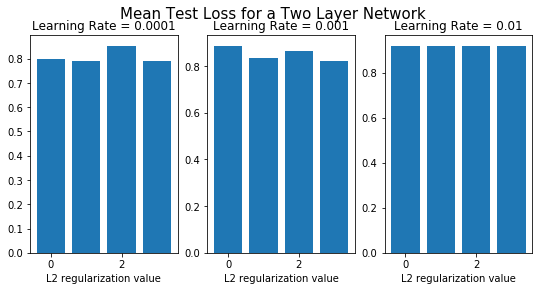

In [5]:
# Print mean test loss for a two-layer network
learning_rates = ['0.0001', '0.001', '0.01']
l2_regs = ['1e-05', '0.0001', '0.01', '0.001']

fig, axes = plt.subplots(
    nrows=1, ncols=len(learning_rates), figsize=(9,4)
    )
for idx, ax in enumerate(axes):
    learning_rate = learning_rates[idx]
    models_to_compare = models_lookuptable['2'][learning_rate]['16']
    test_losses = [np.mean(models_to_compare[l2_reg]['test_loss']) for l2_reg in l2_regs]
    ax.bar(np.arange(len(test_losses)), test_losses)
    ax.set_title("Learning Rate = " + learning_rate)
    ax.set_xlabel("L2 regularization value")
    
plt.suptitle("Mean Test Loss for a Two Layer Network\n", fontsize=15)

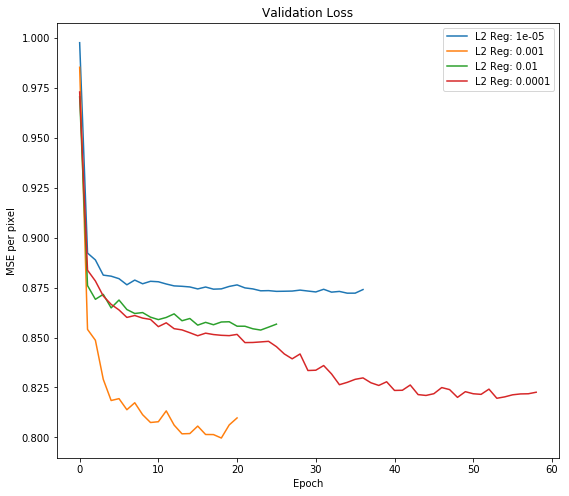

In [6]:
# Number of hidden layers: 3
# Learning rate: 0.01
# Number of lags: 8
plt.figure(figsize=(9,8))
models_to_compare = models_lookuptable['2']['0.001']['16']
for l2_reg in models_to_compare.keys():
    model = models_to_compare[l2_reg]
    plt.plot(
        model['epoch'], model['val_loss'],
        label='L2 Reg: ' + model['l2_reg']
        )
plt.legend()
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE per pixel")
plt.show()

## 3. Load Behave Net neural reconstructions for the best model
Use the best version obtained above

In [7]:
version = best_model['version']

In [8]:
predictions_file = ffdatadir + version + "/" + "predictions.pkl"

In [9]:
with open(predictions_file, "rb") as f:
    predictions_data = pickle.load(f)
predictions = predictions_data['predictions']
predictions_trials = predictions_data['trials']

In [10]:
# Print info about best model
print(version)
print("Mean Test Loss: " + str(np.mean(model['test_loss'])))
print("Best Model Hyperparameters:")
print("Hidden Layers: " + model['n_hid_layers'])
print("Learning Rate: " + model['learning_rate'])
print("Number of Lags: " + model['n_lags'])
print("Regularization Strength: " + model['l2_reg'])

version_8
Mean Test Loss: 0.8345879139723601
Best Model Hyperparameters:
Hidden Layers: 2
Learning Rate: 0.001
Number of Lags: 16
Regularization Strength: 0.0001


## 4. Compare reconstructions with original session data

In [11]:
session = Session("vistrained", mouse, day)
neural_activity = session.neural['neural']

In [12]:
def undo_zscore(neural, predictions):
    """
    Assumes data is trial x time x components
    
    Args:
        neural: original neural activity
        predictions: predicted z-scored activity
    Returns:
        predictions with the z-scoring undone
    """

    predictions = predictions.copy()
    predictions *= np.std(neural, axis=(0,1))
    predictions += np.mean(neural, axis=(0,1))
    return predictions

def zscore(data):
    """
    Assumes data is trial x time x components
    """

    data -= np.mean(data, axis=(0,1))
    data /= np.std(data, axis=(0,1))
    return data

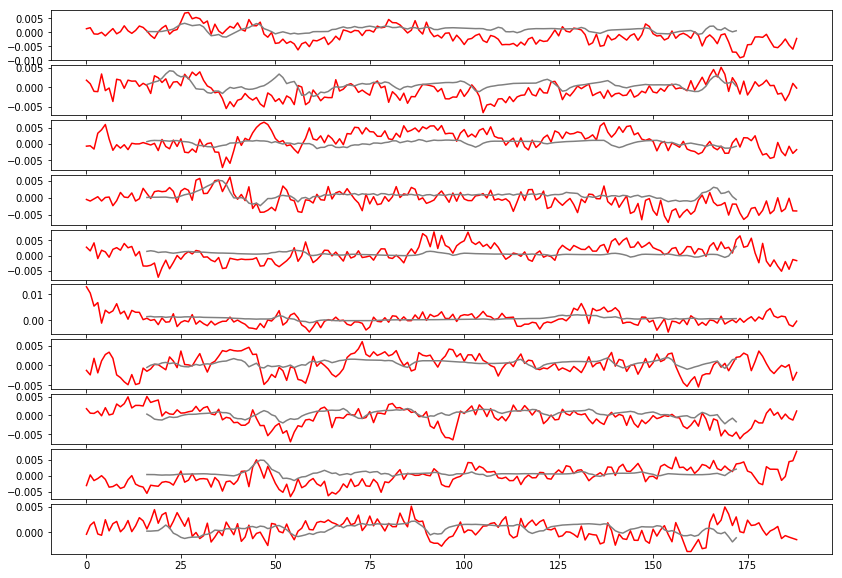

In [16]:
# Plot reconstructions of test trials
num_samples = 10
test_trials = predictions_trials['test']
scaled_predictions = undo_zscore(neural_activity, predictions)
#z_activity = zscore(neural_activity)
fig, axes = plt.subplots(
    nrows=num_samples, ncols=1, figsize=(14,10),
    gridspec_kw={'height_ratios':[1/num_samples]*num_samples, 'hspace':0.1, 'wspace':0.1},
    sharex=False
    )

neuron = np.random.randint(0, 200)
for idx, ax in enumerate(axes):
    trial = test_trials[idx]
    ax.plot(
        neural_activity[trial, :, neuron],
        color='red', label='Original Activity'
        )
    ax.plot(
        scaled_predictions[trial, :, neuron],
        color='gray', label='Reconstruction'# Over the whole trial:
        )

## Which regions are reconstructed best?

In [14]:
# Load session and activity
all_neural_data = session.neural['neural']
delay_period_indices = session.get_delay_period(include_stim=True)
excerpt_indices = []
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0] - 30
    end = delay_period_indices[trial,:][0] + 90
    excerpt_indices.append([start, end])
trial_choices = session.trialmarkers['ResponseSide']
# Extract bins of interest
predictions_excerpt = []
neural_data_excerpt = []
for trial in range(scaled_predictions.shape[0]):
    activity = scaled_predictions[trial,:,:]
    indices = excerpt_indices[trial]
    predictions_excerpt.append(activity[indices[0]:indices[1],:])
    neural_data_excerpt.append(
        all_neural_data[trial,indices[0]:indices[1],:]
        )
scaled_predictions = np.array(predictions_excerpt)
neural_data_excerpt = np.array(neural_data_excerpt)

In [15]:
# Over the whole trial:
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names
r2_df = {}
r2_df['R2 Value'] = []
r2_df['Brain Region'] = []
test_trials = predictions_trials['test']

for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        pred_activity = scaled_predictions[test_trials,:,component-1]
        exp_activity = neural_data_excerpt[test_trials,:,component-1]
        r2 = r2_score(exp_activity, pred_activity)
        r2_df['Brain Region'].append(reg_name)
        r2_df['R2 Value'].append(r2)
r2_df = pd.DataFrame(data=r2_df)

plt.figure(figsize=(7,5))
plt.title("BehaveNet Reconstruction\n" + mouse + ": " + day, fontsize=14)
ax = sns.barplot(
    y="R2 Value", x="Brain Region", data=r2_df
    )
plt.ylabel("R2 Value", fontsize=14)
plt.xlabel("Brain Region", fontsize=14)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [54]:
predictions_trials

{'train': array([355, 356, 357, 358, 359, 360, 361, 362, 345, 346, 347, 348, 349,
        350, 351, 352, 415, 416, 417, 418, 419, 420, 421, 422, 275, 276,
        277, 278, 279, 280, 281, 282, 115, 116, 117, 118, 119, 120, 121,
        122,  25,  26,  27,  28,  29,  30,  31,  32, 335, 336, 337, 338,
        339, 340, 341, 342, 445, 446, 447, 448, 449, 450, 451, 452, 225,
        226, 227, 228, 229, 230, 231, 232, 475, 476, 477, 478, 479, 480,
        481, 482,  45,  46,  47,  48,  49,  50,  51,  52, 105, 106, 107,
        108, 109, 110, 111, 112, 295, 296, 297, 298, 299, 300, 301, 302,
        505, 506, 507, 508, 509, 510, 511, 512, 325, 326, 327, 328, 329,
        330, 331, 332, 405, 406, 407, 408, 409, 410, 411, 412, 375, 376,
        377, 378, 379, 380, 381, 382,  75,  76,  77,  78,  79,  80,  81,
         82, 145, 146, 147, 148, 149, 150, 151, 152, 315, 316, 317, 318,
        319, 320, 321, 322, 285, 286, 287, 288, 289, 290, 291, 292, 465,
        466, 467, 468, 469, 470, 471, 472,

In [57]:
scaled_predictions[354, :,:]

array([[ 0.00115853, -0.00583943,  0.00377636, ..., -0.00030337,
        -0.00099008, -0.00348297],
       [-0.00018491, -0.00435205,  0.00250839, ...,  0.0002232 ,
        -0.00235133, -0.00336271],
       [ 0.00011046, -0.00328256,  0.00149745, ...,  0.00149157,
        -0.00171416, -0.00367995],
       ...,
       [-0.01236497, -0.00185512,  0.00270856, ...,  0.00027806,
        -0.00242225, -0.00128142],
       [-0.01222622, -0.00206668,  0.00243892, ...,  0.00033281,
        -0.00143646, -0.00173915],
       [-0.01286828, -0.00251071,  0.00318215, ..., -0.0001255 ,
        -0.00052224, -0.0014173 ]])